Lecture week 3
==============



## Code preamble



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import pymc3 as pm
import statsmodels.api as sm # check the error that cannot import name 'factorial' in from scipy.misc import factorial
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tensorflow as tf
import altair as alt
# from linearmodels.iv import IV2SLS
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

/opt/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Overview: tensors, first neural network, over/under fitting



### tensors



Knowing how to work with tensors can simplify your code:

-   makes it easier to read and understand
-   both for you and other readers of your code
-   simple example:
    -   5 year fixed effects and 12 month fixed effects
    -   add these together to get the total effect for the 60 months
    -   what are the average total effects per year?



In [9]:
year_effects = np.arange(100,600,100)
month_effects = np.arange(1,13,1)

In [10]:
print(year_effects)
print(month_effects)

[100 200 300 400 500]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


selecting data using masks:



In [12]:
range_x = np.arange(0,2*np.pi,0.01)
range_y = np.sin(range_x)

Plot `sin(x)`, where positive values for `y` are blue and negative ones are red.



Practice with tensors!

Construct a three dimensional tensor



In [14]:
tensor_3d = np.arange(8).reshape(2,2,2)
tensor_3d

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [44]:
print(np.ndim(tensor_3d))

3


-   What is the shape of `tensor_3d`?
-   What does a 3-D vector look like?

Consider the following 3 tensors:



In [16]:
x = np.arange(24).reshape(2,12)
y = np.arange(36).reshape(3,1,12)
z = np.arange(12).reshape(2,3,2)

Which of these can be added together?



In [17]:
# x + y
# x + z
# y + z
# x + y + z

Add dimensions to make sure that they can be added together



In [19]:
x = np.arange(12).reshape(2,2,3)
x

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

Use selections from `x` to get:

-   `[0,1,2]`
-   `[6,8]`
-   `[4,10]`
-   `[11,10,9]`
-   `[7,8,9,10,11]`
-   `[4,5,6,7,8,9]`



In [21]:
x = np.random.normal(0,1,size=20)
y = np.random.normal(0,1,size=20)
z = np.random.choice(3,size=20,replace=True)

-   make a scatter plot of `x` and `y` where the color depends on the value of `z`.



In [45]:
colors = ['ro','bo','go']


**Homework:** Plot red dots, blue triangles and green stars



### first look at neural network



-   this is a very first look at a neural network: do not worry if you don&rsquo;t understand everything now
-   syntax for creating a keras network:
    -   use `keras.Sequential` to create layers of the network, starting with the input layer and ending with the output layer
    -   relu function for intermediate layers
    -   softmax for output layer of a classification problem; if there are, say, 5 classes:
        -   softmax gives you 5 probabilities that add up to 1
        -   highest probability is your prediction for that input

Two dimensional x-variable and the correct label:



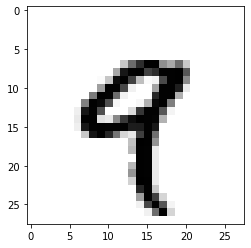

9


In [24]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
plt.imshow(train_images[4],cmap=plt.cm.binary)
plt.show()
print(train_labels[4])

In [46]:
#train_images[4]

-   define the relu and softmax functions and plot these functions



In [48]:
def relu(x):
    return np.clip(x,0,np.inf)
def softmax(x):
    return [np.exp(x[i])/np.sum(np.exp(x)) for i in range(len(x))]

range_x = np.arange(10)-5
###

In [27]:
np.sum(softmax(range_x))

1.0

In [29]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(train_images, train_labels, epochs=5)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 2.6236 - accuracy: 0.8575
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3782 - accuracy: 0.9118
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2819 - accuracy: 0.9299
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2448 - accuracy: 0.9390
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.2633 - accuracy: 0.9417

Test accuracy: 0.9416999816894531


In [31]:
predictions = model.predict(test_images)

In [32]:
predictions[0]

array([2.7939557e-37, 1.2734737e-12, 4.8830423e-10, 7.1526862e-10,
       4.7846206e-15, 1.1186264e-17, 0.0000000e+00, 1.0000000e+00,
       1.9592408e-24, 3.2830120e-14], dtype=float32)

In [33]:
np.argmax(predictions[0])

7

In [34]:
test_labels[0]

7

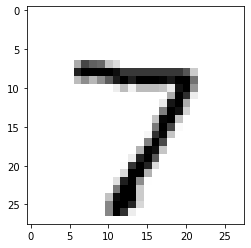

In [35]:
plt.imshow(test_images[0],cmap=plt.cm.binary);

### over/under fitting



-   overfitting: you pick up structure that is particular to the sample but does not generalize to the population
-   underfitting: the sample contains relevant information about the population but your model is too simple to pick this up

First, we generate the data and plot the data

In [36]:
N_observations = 30
train_size = 15
x = np.random.normal(0,1,size=N_observations)
y = x**2 + np.random.normal(0,1,size=N_observations)
x_train = x[:train_size]
x_test = x[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

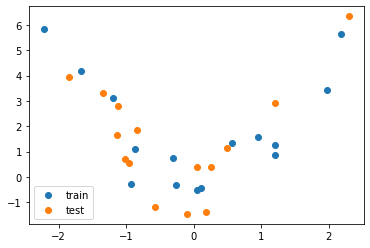

In [37]:
plt.scatter(x_train,y_train,label='train')
plt.scatter(x_test,y_test,label='test')
plt.legend();

Do not worry to much about the syntax of `polyfit` and `poly1d`

In [38]:
z = np.polyfit(x_train, y_train, 2)
p = np.poly1d(z)
range_x = np.arange(np.min(x),np.max(x),0.05)

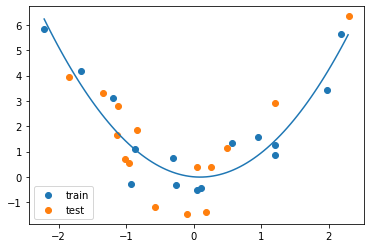

In [39]:
plt.scatter(x_train,y_train,label='train')
plt.scatter(x_test,y_test,label='test')
plt.plot(range_x,p(range_x))
plt.legend();

-   overfitting



-   underfitting



### Next week: neural network and treatment effects



To get an idea of what a neural network is, we look at the python code of a simple implementation of a neural network

-   do not worry about the details of these python programs
-   note that 1 A4 page of code is enough to program the code to solve a neural network
-   updating the weights in the network is actually quite simple



In [49]:
# Code from Chapter 3 of Machine Learning: An Algorithmic Perspective (2nd Edition)
# by Stephen Marsland (http://stephenmonika.net)

# You are free to use, change, or redistribute the code in any way you wish for
# non-commercial purposes, but please maintain the name of the original author.
# This code comes with no warranty of any kind.

# Stephen Marsland, 2008, 2014



class pcn:
	""" A basic Perceptron (the same pcn.py except with the weights printed
	and it does not reorder the inputs)"""

	def __init__(self,inputs,targets):
		""" Constructor """
		# Set up network size
		if np.ndim(inputs)>1:
			self.nIn = np.shape(inputs)[1]
		else:
			self.nIn = 1

		if np.ndim(targets)>1:
			self.nOut = np.shape(targets)[1]
		else:
			self.nOut = 1

		self.nData = np.shape(inputs)[0]

		# Initialise network
		self.weights = np.random.rand(self.nIn+1,self.nOut)*0.1-0.05

	def pcntrain(self,inputs,targets,eta,nIterations):
		""" Train the thing """
		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)

		# Training
		change = range(self.nData)

		for n in range(nIterations):

			self.activations = self.pcnfwd(inputs);
			self.weights -= eta*np.dot(np.transpose(inputs),self.activations-targets)
			print("Iteration: ", n)
			print(self.weights)

			activations = self.pcnfwd(inputs)
			print("Final outputs are:")
			print(activations)
		#return self.weights

	def pcnfwd(self,inputs):
		""" Run the network forward """

		# Compute activations
		activations =  np.dot(inputs,self.weights)

		# Threshold the activations
		return np.where(activations>0,1,0)

	def confmat(self,inputs,targets):
		"""Confusion matrix"""

		# Add the inputs that match the bias node
		inputs = np.concatenate((inputs,-np.ones((self.nData,1))),axis=1)
		outputs = np.dot(inputs,self.weights)

		nClasses = np.shape(targets)[1]

		if nClasses==1:
			nClasses = 2
			outputs = np.where(outputs>0,1,0)
		else:
			# 1-of-N encoding
			outputs = np.argmax(outputs,1)
			targets = np.argmax(targets,1)

		cm = np.zeros((nClasses,nClasses))
		for i in range(nClasses):
			for j in range(nClasses):
				cm[i,j] = np.sum(np.where(outputs==i,1,0)*np.where(targets==j,1,0))

		print(cm)
		print(np.trace(cm)/np.sum(cm))

-   to get used to tensorflow syntax, we program our own OLS regression using tensorflow minimization techniques, that is using derivatives



In [58]:
x = tf.Variable(0.0)
y = tf.Variable(0.0)
def my_function():
    return x**2+y**2-x-y

with tf.GradientTape() as tape:
    value = my_function()
[a.numpy() for a in tape.gradient(value,[x,y])]

[-1.0, -1.0]

In [43]:
x.assign_add(1)
print(x.numpy())

with tf.GradientTape() as tape:
    value = my_function()
tape.gradient(value,[x,y])

1.0


[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.0>]

-   neural network with the handwritten digits data set
    -   if you get bored with numbers, try [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)
-   use `history` method to fine tune the number of epochs to avoid under/over-fitting

-   treatment effects:
    -   we program our own data to see how IV works in identifying causal effects
    -   what can we identify if the effects of a program differ by group?

